
*  **Name: Amir Pourmand**
*  **Std number: 99210259**


## Download Dataset


In [30]:
from zipfile import ZipFile
import os
import numpy as np
import gdown

output = 'images.npy.zip'
url= "https://drive.google.com/u/0/uc?id=1gRylgMQbsdMjdYePhV-03z0VVlfcd21v&export=download"
gdown.download(url, output, quiet=True)
output = 'masks.npy.zip'
url= "https://drive.google.com/u/0/uc?id=1-1NzrnJ1VJ3c9ngSMmGd1qAO9rHuSNZe&export=download"
gdown.download(url, output, quiet=True)


'masks.npy.zip'

In [31]:
with ZipFile('/content/images.npy.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall('/content')

with ZipFile('/content/masks.npy.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall('/content')

os.remove('images.npy.zip')
os.remove('masks.npy.zip')
DIR_PATH = "/content"
X_FILE = "/images_medseg.npy"
Y_FILE = "/masks_medseg.npy"

imgs = np.load(DIR_PATH+X_FILE).astype(np.float32)
msks = np.load(DIR_PATH+Y_FILE).astype(np.float32)

## Visualise the Images

In [32]:
import matplotlib.pyplot as plt


plt.style.use("dark_background")

def visualize(image_batch, mask_batch=None, pred_batch=None, num_samples=8):
    num_classes = mask_batch.shape[-1] if mask_batch is not None else 0
    fix, ax = plt.subplots(num_classes + 1, num_samples, figsize=(num_samples * 2, (num_classes + 1) * 2))
    for i in range(num_samples):
        ax_image = ax[0, i] if num_classes > 0 else ax[i]
        ax_image.imshow(image_batch[i,:,:,0], cmap="Greys")
        ax_image.set_xticks([]) 
        ax_image.set_yticks([])
        
        if mask_batch is not None:
            for j in range(num_classes):
                if pred_batch is None:
                    mask_to_show = mask_batch[i,:,:,j]
                else:
                    mask_to_show = np.zeros(shape=(*mask_batch.shape[1:-1], 3)) 
                    mask_to_show[..., 0] = pred_batch[i,:,:,j] > 0.5
                    mask_to_show[..., 1] = mask_batch[i,:,:,j]
                ax[j + 1, i].imshow(mask_to_show, vmin=0, vmax=1)
                ax[j + 1, i].set_xticks([]) 
                ax[j + 1, i].set_yticks([]) 

    plt.tight_layout()
    plt.show()

***Description***


*   Actual Input
*   Mask for Ground Glass class
*   Mask for Consolidation class
*   Mask for Background Class

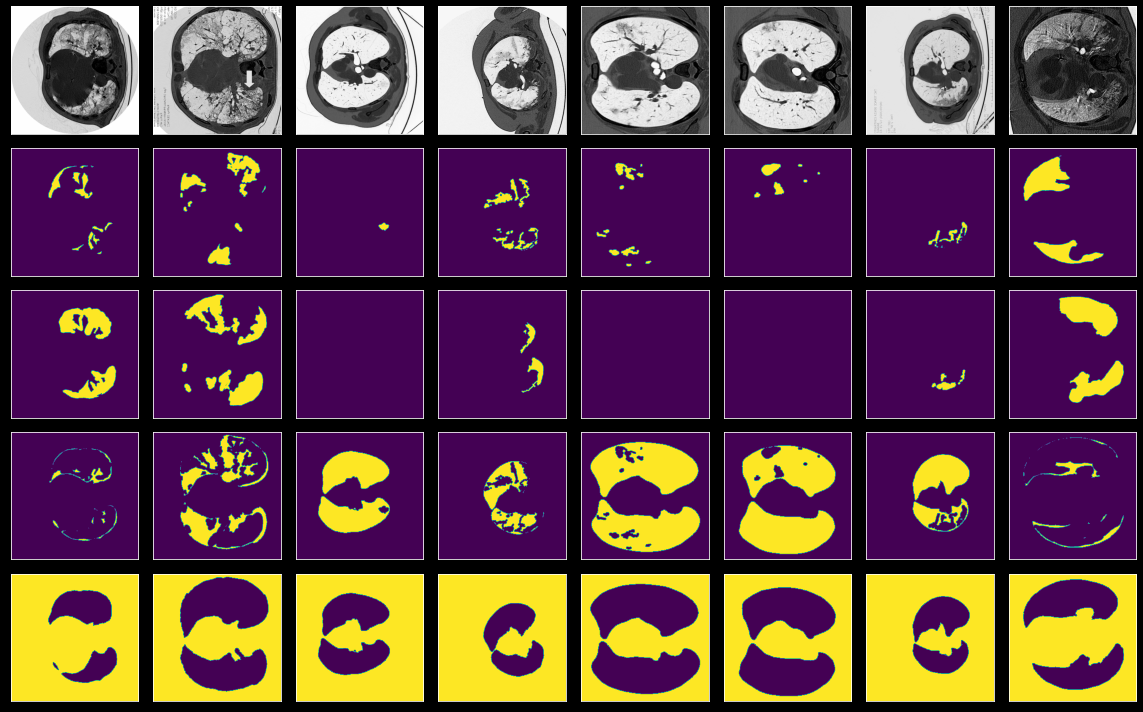

In [33]:
visualize(imgs, msks)

In [35]:
import torch

class Dataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, x, labels):
        'Initialization'
        self.labels = labels
        self.x = x

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.x)

  def __getitem__(self, index):
        'Generates one sample of data'
        x = self.x[index]
        y = self.labels[index]

        return x, y

from torchvision import transforms


temp=torch.tensor( np.moveaxis(imgs, -1, 1))
mytask=torch.tensor(msks[:,:,:,1])
unsqueezed = torch.unsqueeze(mytask,1) 
dataset = Dataset(temp, unsqueezed)

In [36]:
print(imgs.shape)

(100, 512, 512, 1)


## Split Dataset

In [37]:
# 0.1 for test
from torch.utils.data import random_split,DataLoader
from torch.autograd import Variable


val_size = int(np.ceil(len(dataset)*0.1))
train_size = len(dataset) - val_size
train_data,test_data = random_split(dataset,[train_size,val_size])
print("train:",len(train_data))
print("test:",len(test_data))

train: 90
test: 10


## DataLoaders

In [38]:
# batchsize < 5
batch_size=4
train_loader = DataLoader(train_data,batch_size = batch_size,shuffle=True)
test_loader = DataLoader(test_data,batch_size = batch_size,shuffle=True)

## Unet


In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class Up(nn.Module):
    def __init__(self, channel_in, channel_out):
        super(Up, self).__init__()

        ###########################################
        ########### Your Code below
        ###########################################
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')
        self.conv = nn.Sequential(
            nn.Conv2d(
                  channel_in,
                   channel_out,
                   kernel_size=3,
                   padding=1),
                   nn.BatchNorm2d(channel_out),
                   nn.ReLU(inplace=True)
        )
        

    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        diff_x = x1.size()[2] - x2.size()[2]
        diff_y = x1.size()[3] - x2.size()[3]
        # Padding 
        x2 = F.pad(x2, (diff_x // 2, int(diff_x / 2),
                        diff_y // 2, int(diff_y / 2)))
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x       
        ###########################################
        ########### Your Code  
        ###########################################
        

class Down(nn.Module):
    def __init__(self, channel_in, channel_out):
        super(Down, self).__init__()

        ###########################################
        ########### Your Code  
        ###########################################
        super(Down, self).__init__()
        ###########################################
        self.conv = nn.Sequential(
            nn.Conv2d(
                channel_in,
                channel_out,
                kernel_size = 3,
                padding = 1),
                nn.BatchNorm2d(channel_out),
                nn.ReLU(inplace=True)
        )
    
    def forward(self, x):

        ###########################################
        ########### Your Code  
        ###########################################
        x = F.max_pool2d(x,2)
        x = self.conv(x)
        return x

class UNet(nn.Module):
    def __init__(self, channel_in, classes):
        super(UNet, self).__init__()

        ###########################################
        ########### Your Code  
        ###########################################
        self.conv1 = nn.Sequential(
            nn.Conv2d(channel_in, 8, kernel_size=3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(inplace=True)
        )
        self.down1 = Down(8, 16)
        self.down2 = Down(16, 32)
        self.down3 = Down(32, 32)
        self.up1 = Up(64, 16)
        self.up2 = Up(32, 8)
        self.up3 = Up(16, 4)
        self.conv2 = nn.Conv2d(4, classes, kernel_size = 1)
        ########### 
        
    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x = self.up1(x4, x3)
        x = self.up2(x, x2)
        x = self.up3(x, x1)
        x = self.conv2(x)
        x = torch.sigmoid(x)
        return x
    
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        init.xavier_uniform(m.weight, gain=numpy.sqrt(2.0))
        init.constant(m.bias, 0.1)


## IoU

In [40]:
def IoU(output, target):
    smooth = 1e-5
    oss = output > 0.5
    tss = target > 0.5
    intersection = (oss & tss).sum(axis=[1, 2, 3])
    union = (oss | tss).sum(axis=[1, 2, 3])
    IoU = ((intersection + smooth) / (union + smooth)).mean()
    return IoU

## Train and Test

In [41]:

freq = 1
model = UNet(1, 1)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
criterion = nn.BCELoss()

def train(model, epoch):
    ###########################################
    model.train()
    correct = 0
    ###########################################
    for batch_idx, item in enumerate(train_loader):
        ###########################################
        data, target = item
        data = Variable(data)
        target = Variable(target)
        # Normalize Data
        target = (target-torch.min(target))/(torch.max(target)-torch.min(target))
        
        optimizer.zero_grad()
        output = model.forward(data.float())

        loss = criterion(output.float(), target.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        ###########################################
        if batch_idx % freq == 0:
            batch_percent = 100. * batch_idx / len(train_loader)
            print(f'Epoch number:{epoch} '  
                  f'({batch_percent}%)\tLoss:{loss.data:.3f}'
                 )
        ###########################################       
            
            

def test(model):
    ###########################################
    model.eval()
    ###########################################
    loss = iou = 0.
    for item in test_loader:
        ###########################################
        data, target =item
        output = model(data.float())
        # Normalize Data
        target = (target-torch.min(target))/(torch.max(target)-torch.min(target))
        loss += criterion(output.float(), target.float()).data 
        iou += IoU(output, target)   
    loss /= len(test_loader)
    iou /= len(test_loader)
    print(f'Average loss:{loss:.3f}\nIoU:{iou:.3f}\n')
    return loss 
    ###########################################

Num_of_eopchs = 5

losses = []
for epoch in range(1, Num_of_eopchs):
    train(model, epoch)
    loss= test(model)
    losses.append(loss)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Epoch number:1 (0.0%)	Loss:0.468
Epoch number:1 (4.3478260869565215%)	Loss:0.441
Epoch number:1 (8.695652173913043%)	Loss:0.449
Epoch number:1 (13.043478260869565%)	Loss:0.409
Epoch number:1 (17.391304347826086%)	Loss:0.413
Epoch number:1 (21.73913043478261%)	Loss:0.403
Epoch number:1 (26.08695652173913%)	Loss:0.398
Epoch number:1 (30.434782608695652%)	Loss:0.373
Epoch number:1 (34.78260869565217%)	Loss:0.367
Epoch number:1 (39.130434782608695%)	Loss:0.343
Epoch number:1 (43.47826086956522%)	Loss:0.386
Epoch number:1 (47.82608695652174%)	Loss:0.330
Epoch number:1 (52.17391304347826%)	Loss:0.326
Epoch number:1 (56.52173913043478%)	Loss:0.316
Epoch number:1 (60.869565217391305%)	Loss:0.306
Epoch number:1 (65.21739130434783%)	Loss:0.314
Epoch number:1 (69.56521739130434%)	Loss:0.288
Epoch number:1 (73.91304347826087%)	Loss:0.314
Epoch number:1 (78.26086956521739%)	Loss:0.273
Epoch number:1 (82.6086956521739%)	Loss:0.272
Epoch number:1 (86.95652173913044%)	Loss:0.311
Epoch number:1 (91.304

## Plot the result

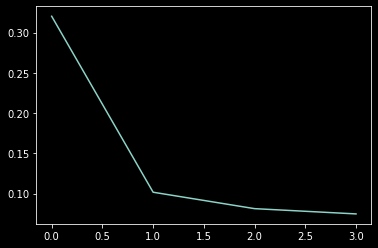

In [44]:
import matplotlib.pyplot as plt

plt.plot(np.arange(0,epoch),losses)

## Segment Output for Ground Glass

In [45]:
def moveColumn(item):
    return torch.moveaxis(item, 1, -1)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


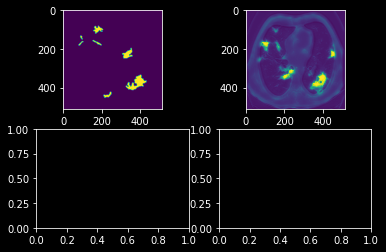

In [78]:
with torch.no_grad():
    test_data,test_target=next(iter(test_loader))
    result = model(test_data)

    f, axarr = plt.subplots(2,2)
    axarr[0,0].imshow(np.squeeze( moveColumn(test_target)[0]))
    axarr[0,1].imshow(np.squeeze(moveColumn(result[0])))

## Improve U-Net (bonus)
